In [27]:
import fiona, utm, os, re
import datetime
import rasterio
import pandas as pd
from rasterio.mask import mask
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
fields = {}
field_names = ['20', '21', '22', '23', '17', '18']
for field_name in field_names:
    with fiona.open('/Users/vasilii/Desktop/research/rostov/rassvetQGIS.GEOJSON', 'r') as shapefile:
        fields[field_name] = [feature['geometry'] for feature in shapefile
                              if feature['properties']['name'] == field_name]
        
for field_name in field_names:
    for field in fields[field_name]:
        if field['type']=='Polygon':
            field['coordinates'] = [[utm.from_latlon(i[1], i[0])[:2] for i in field['coordinates'][0]]]
        else:
            geoms = []
            for geom in field['coordinates']:
                geoms.append([[utm.from_latlon(i[1], i[0])[:2] for i in geom[0]]])
            field['coordinates'] = geoms

# Sentinel 2

In [13]:
ndvis = {}
for field_name in field_names:
    ndvis[field_name] = {}

In [4]:
root = '/Users/vasilii/Desktop/sentinel/'
for folder in tqdm(next(os.walk(root))[1]):
    date = re.findall('(\d+)T', folder)[-1]
    for granule in next(os.walk(root+folder+'/GRANULE'))[1]:
        if 'T37TFM' in granule:
            for image in next(os.walk(root+folder+'/GRANULE/'+granule+'/IMG_DATA'))[2]:
                if '_B04.jp2' in image and 'aux.xml' not in image:
                    band_04 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
                elif '_B08.jp2' in image and 'aux.xml' not in image:
                    band_08 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
    
    for field_name in field_names:
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_08 = mask(band_08, fields[field_name], nodata=0, crop=True)

        field_04 = masked_04[0].data[0].astype('int16')
        field_08 = masked_08[0].data[0].astype('int16')

        field_04 = field_04[np.nonzero(field_04)]
        field_08 = field_08[np.nonzero(field_08)]
        
        ndvi = (field_08-field_04)/(field_08+field_04)
        ndvis[field_name][datetime.datetime.strptime(date, '%Y%m%d').date()] = (np.mean(ndvi), np.std(ndvi))
    
    band_04.close()
    band_08.close()

100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


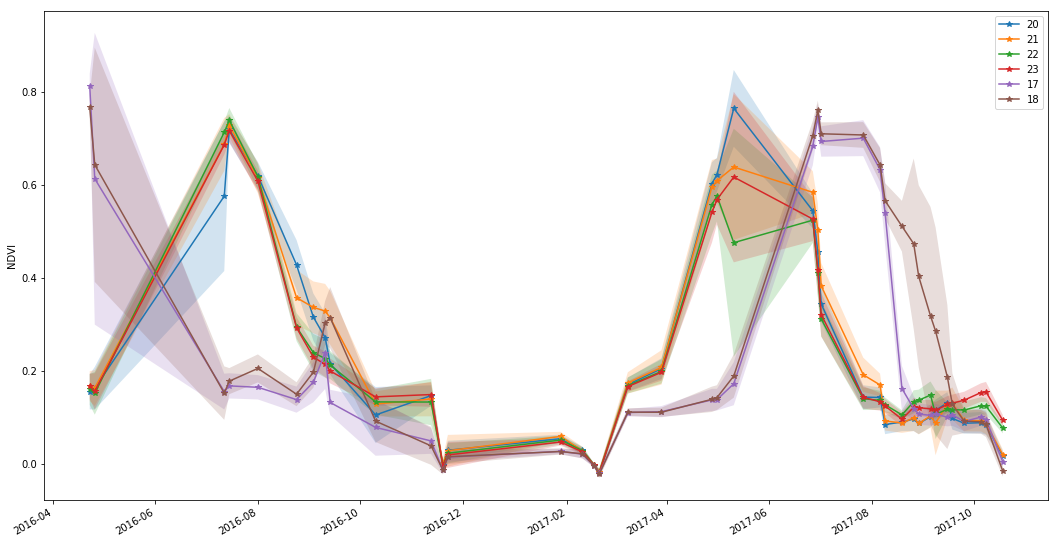

In [7]:
plt.figure(figsize=(18,10))
for field_name in field_names:
    plt.plot(sorted(ndvis[field_name]), [ndvis[field_name][date][0] for date in sorted(ndvis[field_name])],
             '*-', label=field_name)
    plt.fill_between(sorted(ndvis[field_name]), 
                 [ndvis[field_name][date][0]+ndvis[field_name][date][1] for date in sorted(ndvis[field_name])],
                 [ndvis[field_name][date][0]-ndvis[field_name][date][1] for date in sorted(ndvis[field_name])],
                     alpha=0.2)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('NDVI')
plt.show()

In [8]:
# first values in tuples - NDVI mean per field
# second values in tuples - NDVI std per field
pd.DataFrame(ndvis)

,17,18,20,21,22,23
2016-04-23,"(0.8123705640349941, 0.026687040966795493)","(0.7666289246595589, 0.026300232652523806)","(0.15582409071844988, 0.03760650462925701)","(0.1680861602477478, 0.03202180989781307)","(0.16104702780307817, 0.033173533911362525)","(0.167780544999831, 0.02705614529538686)"
2016-04-26,"(0.6134657625612283, 0.3132434355289365)","(0.6435033411569517, 0.2515146040840724)","(0.16360397557299697, 0.045725919046427047)","(0.16414652540675345, 0.03859775270593556)","(0.15274606660412232, 0.04581518380854367)","(0.1569700077657626, 0.039019180357943176)"
2016-07-12,"(0.15643454640848814, 0.03841084370352388)","(0.1531355832171518, 0.05738174603024561)","(0.5760710625271473, 0.1607050835835897)","(0.6872195938090409, 0.056789940946996735)","(0.7132367588418201, 0.023247968762552508)","(0.6864432899431713, 0.021461723792607874)"
2016-07-15,"(0.1686514865778789, 0.027114063539895795)","(0.17882435902763383, 0.028042596643937618)","(0.7193612746818993, 0.02910487374993759)","(0.7279597841920719, 0.024260184272441043)","(0.739219269952517, 0.026223451522101576)","(0.7168016621231527, 0.024162863389254267)"
2016-08-01,"(0.1656329837363613, 0.026122415727452022)","(0.20615464493485872, 0.030083209887311172)","(0.6196582102806298, 0.029891716616714775)","(0.6151530467773739, 0.03285830495304474)","(0.618126154993496, 0.027164163142055484)","(0.6084134375274031, 0.022287110864727875)"
2016-08-24,"(0.13916115846378502, 0.028088713539796247)","(0.15076665905545206, 0.02566688323648463)","(0.4283538675519669, 0.053533788723005425)","(0.35808012598404027, 0.05971116764078194)","(0.2949005566506564, 0.03007141727840208)","(0.2935252737101558, 0.02299711617421445)"
2016-09-03,"(0.17679161084580158, 0.04330656856363059)","(0.19813479790447147, 0.03339958695535651)","(0.31626398091123414, 0.05067730338095054)","(0.3372360296043861, 0.0556767767828933)","(0.24000500133355795, 0.040225598703388474)","(0.23020581494959305, 0.02472564923405562)"
2016-09-10,"(0.2399187226971659, 0.07796371947535395)","(0.30377112141890095, 0.04719954679852567)","(0.2723940349225486, 0.05235127214011079)","(0.329342366370871, 0.05832605680935371)","(0.22738073765924985, 0.040893707134344565)","(0.21511827118150836, 0.027413017973341853)"
2016-09-13,"(0.13306463527359894, 0.02719902601969144)","(0.3149574938802624, 0.06571533091269934)","(0.2163958361640434, 0.02323204240586844)","(0.3149116892089442, 0.05769835309940463)","(0.21341972129473524, 0.030054969654353548)","(0.20067224744244092, 0.02671670313373403)"
2016-10-10,"(0.0794958525842471, 0.06084084674549069)","(0.09296715047248943, 0.0449489391585316)","(0.10617700772598172, 0.06004768841720947)","(0.12966085295448898, 0.026869044964383894)","(0.13423041273519207, 0.027468372955885313)","(0.14509395176975312, 0.018496538960051732)"


# Landsat 8

In [14]:
root = '/Users/vasilii/Desktop/landsat/'
for folder in tqdm(next(os.walk(root))[1]):
    date = folder.split('_')[3]

    band_04 = rasterio.open(root+folder+'/'+folder+'_B4.TIF')
    band_05 = rasterio.open(root+folder+'/'+folder+'_B5.TIF')
    meta = open(root+folder+'/'+folder+'_MTL.txt')
    meta = meta.read()
    
    mult_04 = float(re.findall('REFLECTANCE_MULT_BAND_4 = (.+)\n', meta)[0])
    mult_05 = float(re.findall('REFLECTANCE_MULT_BAND_5 = (.+)\n', meta)[0])

    add_04 = float(re.findall('REFLECTANCE_ADD_BAND_4 = (.+)\n', meta)[0])
    add_05 = float(re.findall('REFLECTANCE_ADD_BAND_5 = (.+)\n', meta)[0])
    
    se = float(re.findall('SUN_ELEVATION = (.+)\n', meta)[0])
    
    for field_name in field_names:
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_05 = mask(band_05, fields[field_name], nodata=0, crop=True)

        field_04 = masked_04[0].data[0].astype('int16')
        field_05 = masked_05[0].data[0].astype('int16')

        field_04 = field_04[np.nonzero(field_04)]
        field_05 = field_05[np.nonzero(field_05)]
        
        field_04 = (field_04 * mult_04 + add_04)/np.sin(se*np.pi/180.0)
        field_05 = (field_05 * mult_05 + add_05)/np.sin(se*np.pi/180.0)
        
        ndvi = (field_05-field_04)/(field_05+field_04)
        ndvis[field_name][datetime.datetime.strptime(date, '%Y%m%d').date()] = (np.mean(ndvi), np.std(ndvi))
    
    band_04.close()
    band_05.close()

100%|██████████| 13/13 [00:00<00:00, 87.22it/s]


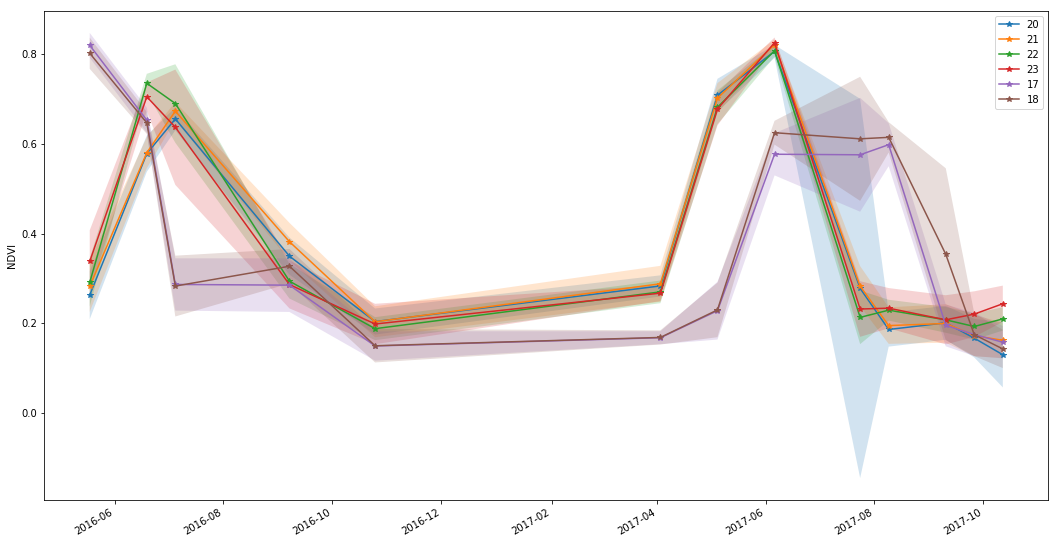

In [15]:
plt.figure(figsize=(18,10))
for field_name in field_names:
    plt.plot(sorted(ndvis[field_name]), [ndvis[field_name][date][0] for date in sorted(ndvis[field_name])],
             '*-', label=field_name)
    plt.fill_between(sorted(ndvis[field_name]), 
                 [ndvis[field_name][date][0]+ndvis[field_name][date][1] for date in sorted(ndvis[field_name])],
                 [ndvis[field_name][date][0]-ndvis[field_name][date][1] for date in sorted(ndvis[field_name])],
                     alpha=0.2)
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel('NDVI')
plt.show()

In [16]:
# first values in tuples - NDVI mean per field
# second values in tuples - NDVI std per field
pd.DataFrame(ndvis)

,17,18,20,21,22,23
2016-05-18,"(0.8203385049493506, 0.02770751104962272)","(0.8026810970095748, 0.03479278635675146)","(0.2626435502285086, 0.053824943631574355)","(0.2821010494750133, 0.05688604638962813)","(0.2908946972179668, 0.05343806484652814)","(0.3378138888514202, 0.06945154187158951)"
2016-06-19,"(0.6533363512942131, 0.027945161607571097)","(0.6471249724879522, 0.02457132488394175)","(0.5783545917100156, 0.040456267623530544)","(0.5805033980403478, 0.03459974393528112)","(0.735571214554821, 0.02113261746024301)","(0.7055350304029887, 0.03178471556259136)"
2016-07-05,"(0.28633109112370947, 0.05836490559469469)","(0.2827159307116359, 0.06785470994602748)","(0.6560080117123681, 0.02550900468360409)","(0.6734633689874302, 0.02020861931733617)","(0.6904057924000289, 0.0876773146715089)","(0.6374477342841945, 0.12880473871128262)"
2016-09-07,"(0.2847777894875167, 0.05984675055932682)","(0.32702225015014624, 0.03849169523345259)","(0.3494906968599554, 0.041535488783330264)","(0.381797616629864, 0.042085010182447834)","(0.29362911334986835, 0.03878916118152707)","(0.2860852460378977, 0.05331208810059154)"
2016-10-25,"(0.14892886233524577, 0.0327784124790944)","(0.1494651772424114, 0.037305139807664346)","(0.20352459099992876, 0.029111975558219535)","(0.20300169190891518, 0.03461601964129778)","(0.1876065798379006, 0.02567581267227981)","(0.19801907902722823, 0.04514286657001491)"
2017-04-03,"(0.16739933291475925, 0.014447810666525097)","(0.16802379110310287, 0.015848905033481617)","(0.2830561254199028, 0.02359929466089457)","(0.2878670406327232, 0.040070651175113756)","(0.2697785978543903, 0.025289120828908634)","(0.2669506816802262, 0.017857882575828442)"
2017-05-05,"(0.22776546688684174, 0.06448580038337041)","(0.2294911100122486, 0.060909778527174094)","(0.7089161443372731, 0.03665058685364058)","(0.7025885703533639, 0.03333902169692846)","(0.6820383827363335, 0.03765344092981396)","(0.6781248079949405, 0.03678256721342565)"
2017-06-06,"(0.577122816694999, 0.047197437973346905)","(0.6252046195925344, 0.026562297849233994)","(0.8069182843215761, 0.014421517813872766)","(0.8218167562667619, 0.011617075192513137)","(0.8081612638409011, 0.013247714943332408)","(0.8262895687695894, 0.011434999635616274)"
2017-07-24,"(0.575900841779506, 0.1270850055785537)","(0.6115509161722861, 0.13851586540829797)","(0.2774407408188656, 0.42333127739643)","(0.28244579162154126, 0.04481537987704301)","(0.2128350171092354, 0.059741660282420735)","(0.23148261596493777, 0.062079695198568784)"
2017-08-09,"(0.598470353304393, 0.04803326880588627)","(0.6148589696078166, 0.03390031543668456)","(0.18579484700764626, 0.03830822854171664)","(0.19449042413949622, 0.040769051018123656)","(0.22893940150135628, 0.0232420534235027)","(0.23338697448893433, 0.04490168869369651)"


# All Fields

In [2]:
br1 = pd.read_excel('Структура посевных площадей на 2016.xls', sheet_name='бр 1', skiprows=6, skip_footer=20, 
                  index_col=0, usecols=[0, 1, 8])
br2 = pd.read_excel('Структура посевных площадей на 2016.xls', sheet_name='бр 2', skiprows=6, skip_footer=29, 
                  index_col=0, usecols=[0, 1, 8])
br3 = pd.read_excel('Структура посевных площадей на 2016.xls', sheet_name='бр 3', skiprows=6, skip_footer=23, 
                  index_col=0, usecols=[0, 1, 8])

In [3]:
fields_stat = pd.concat([br1, br2, br3])

In [4]:
fields_stat.index = fields_stat.index.astype('str')

In [5]:
fields = {}
field_names = [a for a in fields_stat.index]
for field_name in field_names:
    with fiona.open('/Users/vasilii/Desktop/research/rostov/rassvetQGIS.GEOJSON', 'r') as shapefile:
        fields[field_name] = [feature['geometry'] for feature in shapefile
                              if feature['properties']['name'] == field_name]
        
for field_name in field_names:
    for field in fields[field_name]:
        if field['type']=='Polygon':
            field['coordinates'] = [[utm.from_latlon(i[1], i[0])[:2] for i in field['coordinates'][0]]]
        else:
            geoms = []
            for geom in field['coordinates']:
                geoms.append([[utm.from_latlon(i[1], i[0])[:2] for i in geom[0]]])
            field['coordinates'] = geoms

In [6]:
ndvis = {}
for field_name in field_names:
    ndvis[field_name] = {}

In [7]:
root = '/Users/vasilii/Desktop/sentinel/'
for folder in tqdm(next(os.walk(root))[1]):
    date = re.findall('(\d+)T', folder)[-1]
    if date[:4] == '2017':
        continue
    for granule in next(os.walk(root+folder+'/GRANULE'))[1]:
        if 'T37TFM' in granule:
            for image in next(os.walk(root+folder+'/GRANULE/'+granule+'/IMG_DATA'))[2]:
                if '_B04.jp2' in image and 'aux.xml' not in image:
                    band_04 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
                elif '_B08.jp2' in image and 'aux.xml' not in image:
                    band_08 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
    
    for field_name in field_names:
        if fields[field_name] == []:
            continue
        masked_04 = mask(band_04, fields[field_name], nodata=0, crop=True)
        masked_08 = mask(band_08, fields[field_name], nodata=0, crop=True)

        field_04 = masked_04[0].data[0].astype('int16')
        field_08 = masked_08[0].data[0].astype('int16')

        field_04 = field_04[np.nonzero(field_04)]
        field_08 = field_08[np.nonzero(field_08)]
        
        ndvi = (field_08-field_04)/(field_08+field_04)
        ndvis[field_name][datetime.datetime.strptime(date, '%Y%m%d').date()] = (np.mean(ndvi), np.std(ndvi))
    
    band_04.close()
    band_08.close()

100%|██████████| 39/39 [00:31<00:00,  1.26it/s]


In [8]:
ndvi_per_field = {}
for field in ndvis:
    if ndvis[field] != {}:
        ndvi_per_field[field] = [ndvis[field][date][0] for date in sorted(ndvis[field])]

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=2)

In [11]:
ndvi_pca = pca.fit_transform([ndvi_per_field[field] for field in ndvi_per_field])

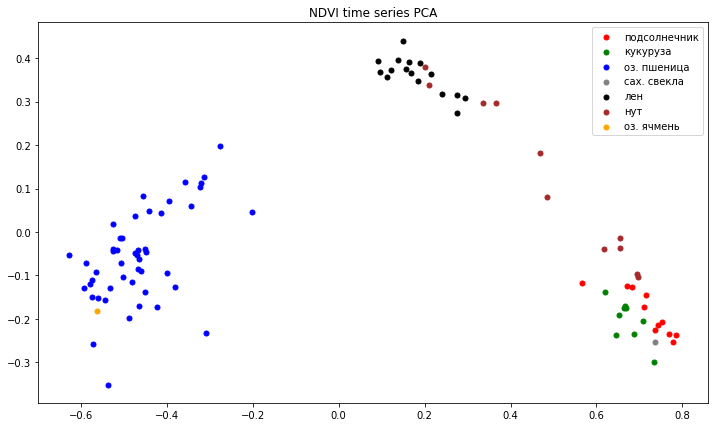

In [12]:
coloring = {'подсолнечник':1, 'кукуруза':2, 'оз. пшеница':3, 'сах. свекла':4, 'лен':5, 'нут':6, 'оз. ячмень':7}

plt.figure(figsize=(12,7))
for veg, col in zip(['подсолнечник', 'кукуруза', 'оз. пшеница', 'сах. свекла', 'лен', 'нут', 'оз. ячмень'],
                   ['red', 'green', 'blue', 'grey', 'black', 'brown', 'orange']):
    plt.scatter(ndvi_pca[np.where(np.array([fields_stat.loc[key][2016] for key in ndvi_per_field.keys()])==veg)][:,0], 
                ndvi_pca[np.where(np.array([fields_stat.loc[key][2016] for key in ndvi_per_field.keys()])==veg)][:,1],
                s=25, c=col, label=veg)
plt.legend()
plt.title('NDVI time series PCA')
plt.show()

# Problem field 19 in 2016

Here I am doing the intrafield per-pixel analysis of NDVI values of the pixels of the field 19 through all 2016 year period. There was sunflower seeded on this field in 2016 and this field was damaged by molluscs. It is interesting to analyze per-pixel NDVI time-series to detect problem zones in this field 19.

In [18]:
# read polygon

with fiona.open('/Users/vasilii/Desktop/research/rostov/rassvetQGIS.GEOJSON', 'r') as shapefile:
    field_19 = [feature['geometry'] for feature in shapefile if feature['properties']['name'] == '19']
    
for entity in field_19:
    entity['coordinates'] = [[utm.from_latlon(i[1], i[0])[:2] for i in entity['coordinates'][0]]]

In [40]:
# read NDVI maps

ndvis, dates = [], []
root = '/Users/vasilii/Desktop/sentinel/'

for folder in tqdm(next(os.walk(root))[1]):
    date = re.findall('(\d+)T', folder)[-1]
    if date[:4] == '2017':
        continue
    for granule in next(os.walk(root+folder+'/GRANULE'))[1]:
        if 'T37TFM' in granule:
            for image in next(os.walk(root+folder+'/GRANULE/'+granule+'/IMG_DATA'))[2]:
                if '_B04.jp2' in image and 'aux.xml' not in image:
                    band_04 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
                elif '_B08.jp2' in image and 'aux.xml' not in image:
                    band_08 = rasterio.open(root+folder+'/GRANULE/'+granule+'/IMG_DATA/'+image)
    
    masked_04 = mask(band_04, field_19, nodata=0, crop=True)
    masked_08 = mask(band_08, field_19, nodata=0, crop=True)

    masked_04 = masked_04[0].data[0].astype('int16')
    masked_08 = masked_08[0].data[0].astype('int16')

    masked_04 = masked_04[np.nonzero(masked_04)]
    masked_08 = masked_08[np.nonzero(masked_08)]

    ndvis.append((masked_08-masked_04)/(masked_08+masked_04))
    dates.append(datetime.datetime.strptime(date, '%Y%m%d').date())
    
    band_04.close()
    band_08.close()

100%|██████████| 39/39 [00:06<00:00,  6.35it/s]


In [58]:
# sort values wrt dates

ndvis = [ndvis[i] for i in np.argsort(dates)]
dates = np.sort(dates)

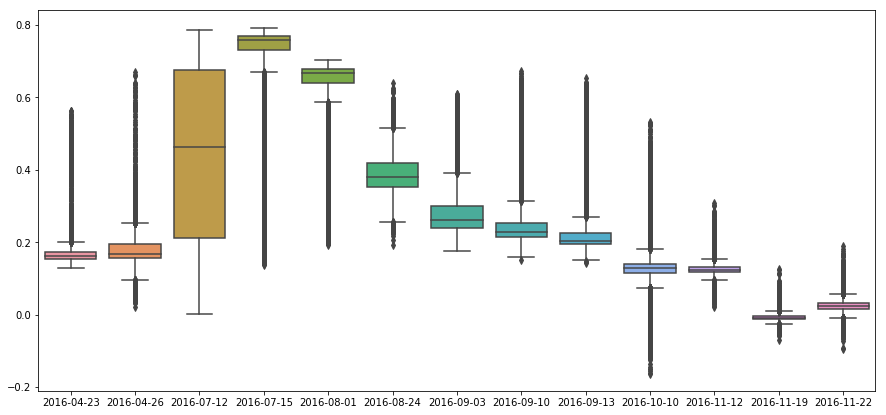

In [60]:
# boxplots of NDVI values for field 19 
# over different timestamps

plt.figure(figsize=(15,7))
sns.boxplot(dates, ndvis)
plt.show()